In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import binom
import pickle as pkl
from glob import glob
from os import path as op
from itertools import combinations, pairwise
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
def calc_p_binom(obs_acc, trial_df, query_str, prob=0.5):

    n = round(trial_df.query(query_str).shape[0])

    k = np.arange(0, n + 1)
    probabilities = sp.stats.binom.pmf(k, n, prob)

    return probabilities[int(obs_acc*n)]

In [100]:
def plot_AM(data, metric):
    ''' Helper function to plot accuracy matrices after 
        fitting models'''

    # Extract unique values
    unique_vals = sorted(set(int(x) for key in data.keys() for x in key.split('_')))
    size = len(unique_vals)

    # Map actual values to matrix indices
    val_to_idx = {val: i for i, val in enumerate(unique_vals)}

    # Initialize matrix
    matrix = np.full((size, size), np.nan)

    # Convert keys into lists for indexed access
    pairs = list(data.keys())

    # Fill matrix using enumerate
    for i, key in enumerate(pairs):
        val1, val2 = map(int, key.split('_'))
        idx1, idx2 = val_to_idx[val1], val_to_idx[val2]
        matrix[idx1, idx2] = data[key][metric]
        matrix[idx2, idx1] = data[key][metric]  # Ensure symmetry

    # Convert to DataFrame with proper labels
    df = pd.DataFrame(matrix, index=unique_vals, columns=unique_vals)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    
    if 'acc' in metric:
        sns.heatmap(df, annot=True, cmap='coolwarm', vmin=.1, vmax=1, linewidths=0.5)
    else:
        sns.heatmap(df, annot=True, cmap='coolwarm', vmin=0,vmax=2.9957,linewidths=0.5)
        
    plt.title(f"Pairwise Accuracy Heatmap ({metric})")
    plt.show()

    return df

In [77]:
def average_results(class_type, files):

    n_obs = len(correct_sol_files)

    avg_results = {}
#     avg_results['class_type'] = class_type

    for file in files:

        file_data = open(file, 'rb')
        data = pkl.load(file_data)

        if 'dots' in file_name:
            form = 'form=="dot"'
        elif 'digit' in file_name:
            form = 'form=="digit"'
        else:
            form = '(form=="digit"|form=="dot")'

        for key in data.keys():

            obs_acc = data[key]['xgb_score']
            query = f'(value=={int(key[0])} | value=={int(key[2])}) & {form}'
            p_val_binom = calc_p_binom(obs_acc, trial_long, query, prob=0.5)
            p_val_perm = data[key]['xgb_pvalue']

            if key in avg_results.keys():

                avg_results[key]['obs_acc'] += obs_acc
                avg_results[key]['p_val_binom'] += p_val_binom
                avg_results[key]['p_val_perm'] += p_val_perm

            else:
                avg_results[key] = {}
                avg_results[key]['obs_acc'] = obs_acc
                avg_results[key]['p_val_binom'] = p_val_binom
                avg_results[key]['p_val_perm'] = p_val_perm


    for key in avg_results.keys():

        avg_results[key]['obs_acc'] =  avg_results[key]['obs_acc']/n_obs
        avg_results[key]['p_val_binom'] =  avg_results[key]['p_val_binom']/n_obs
        avg_results[key]['log_p_val_binom'] = -1*np.log(avg_results[key]['p_val_binom'])
        avg_results[key]['p_val_perm'] =  avg_results[key]['p_val_perm']/n_obs
        avg_results[key]['log_p_val_perm'] = -1*np.log(avg_results[key]['p_val_perm'])

    
    
    return (class_type, avg_results)

In [2]:
data_dir='/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/'
sub = ["BLC_1043_2", "ENI_032", "ENI_195"]
subs_dict = {}

perm_files = glob(op.join(data_dir, "*.pickle"))


In [3]:
trial_df = pd.read_csv('trial_info.csv',index_col=False)

In [5]:
trial_long = trial_df.melt(id_vars=['correct','form'], value_vars=['operand_1', 'operand_2','solution'])

In [7]:
perm_files

['/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/BLC_1043_2_labels_numerosity_dots_perm_results.pickle',
 '/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/BLC_1043_2_labels_correct_eq_perm_results.pickle',
 '/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/ENI_195_labels_correct_correct_perm_results.pickle',
 '/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/ENI_032_labels_numerosity_digits_perm_results.pickle',
 '/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/ENI_032_labels_numerosity_combined_perm_results.pickle',
 '/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/BLC_1043_2_labels_numerosity_combined_perm_results.pickle',
 '/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/ENI_032_labels_numerosity_dots_perm_results.pickle',
 '/scratch/users/ethanroy/eeg_groupitizing_data/results/perm_results/ENI_195_labels_numerosity_dots_perm_results.pickle',
 '/scratch

## Evaluate True/False Classifiations

In [78]:
correct_sol_files = glob(op.join(data_dir, "*_labels_correct_correct_perm_results.pickle"))
average_results('correct_solution', correct_sol_files)

('correct_solution',
 {'0_1': {'obs_acc': np.float64(0.5708333333333333),
   'p_val_binom': np.float64(0.0992936838883907),
   'p_val_perm': np.float64(0.19247419247419248),
   'log_p_val_binom': np.float64(2.3096733163145977),
   'log_p_val_perm': np.float64(1.6477931993109527)}})

In [110]:
correct_sol_files = glob(op.join(data_dir, "*labels_correct_eq_perm_results.pickle"))
average_results('correct_eq', correct_sol_files)

('correct_eq',
 {'0_1': {'obs_acc': np.float64(0.48333333333333334),
   'p_val_binom': np.float64(0.11253284174017607),
   'p_val_perm': np.float64(0.6023976023976024),
   'log_p_val_binom': np.float64(2.1845101733605925),
   'log_p_val_perm': np.float64(0.5068375825880351)}})

## Combined Numerosity

In [79]:
combined_numerosity_files = glob(op.join(data_dir, '*_labels_numerosity_combined_perm_results.pickle'))

combined_numerosity_results = average_results('combined_numerosity', combined_numerosity_files)

In [80]:
combined_numerosity_results_df = pd.DataFrame.from_dict(combined_numerosity_results[1], orient='index').reset_index(names=['pair'])

combined_numerosity_results_df[['class_1', 'class_2']] = combined_numerosity_results_df['pair'].str.split('_', expand=True)

combined_numerosity_results_df = combined_numerosity_results_df[combined_numerosity_results_df['class_2']!='100']


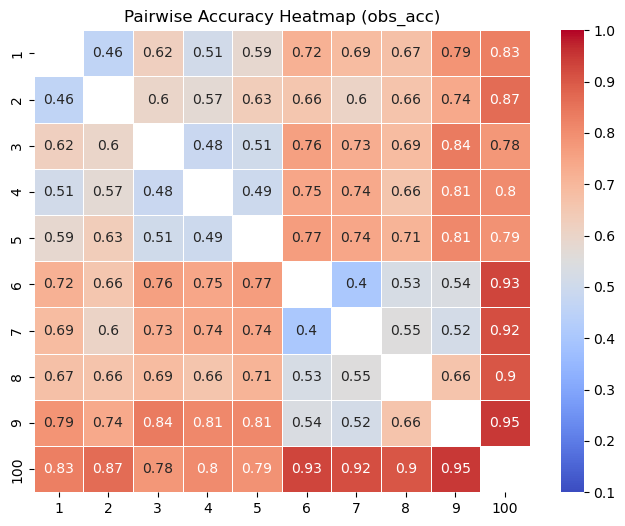

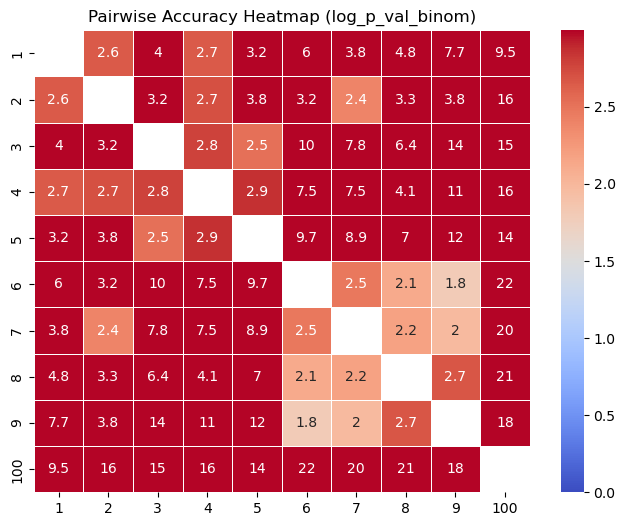

,1,2,3,4,5,6,7,8,9,100
1,NaN,2.648051,3.979107,2.651945,3.241214,5.976460,3.832903,4.840917,7.695964,9.455171
2,2.648051,NaN,3.201470,2.703443,3.805221,3.186743,2.398211,3.257238,3.836166,15.924998
3,3.979107,3.201470,NaN,2.777958,2.524268,10.133539,7.768957,6.377318,14.017726,15.345499
4,2.651945,2.703443,2.777958,NaN,2.858541,7.540562,7.502717,4.126633,10.879901,15.972494
5,3.241214,3.805221,2.524268,2.858541,NaN,9.708132,8.913421,7.001198,11.575663,13.970746
6,5.976460,3.186743,10.133539,7.540562,9.708132,NaN,2.472179,2.110549,1.798673,21.700455
7,3.832903,2.398211,7.768957,7.502717,8.913421,2.472179,NaN,2.182160,1.968627,19.882131
8,4.840917,3.257238,6.377318,4.126633,7.001198,2.110549,2.182160,NaN,2.668578,20.940645
9,7.695964,3.836166,14.017726,10.879901,11.575663,1.798673,1.968627,2.668578,NaN,18.243791
100,9.455171,15.924998,15.345499,15.972494,13.970746,21.700455,19.882131,20.940645,18.243791,NaN


In [102]:
plot_AM(combined_numerosity_results[1], 'obs_acc')

plot_AM(combined_numerosity_results[1], 'log_p_val_binom')

## Dots Only

In [97]:
dot_numerosity_files = glob(op.join(data_dir, '*_labels_numerosity_dots_perm_results.pickle'))

dot_numerosity_results = average_results('dots_numerosity', dot_numerosity_files)

plot_AM(dot_numerosity_results[1], 'obs_acc')

plot_AM(dot_numerosity_results[1], 'log_p_val_binom')

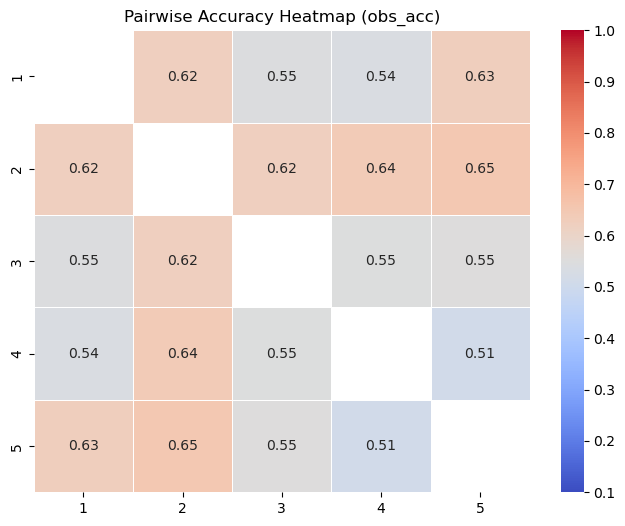

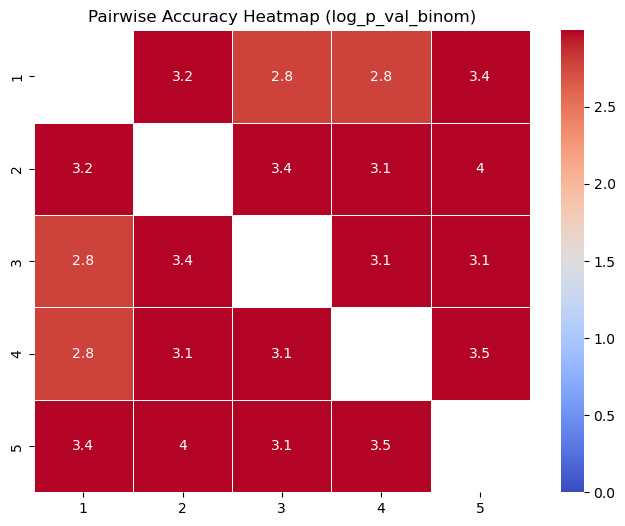

,1,2,3,4,5
1,NaN,3.248435,2.784013,2.782282,3.414733
2,3.248435,NaN,3.423895,3.083438,3.957497
3,2.784013,3.423895,NaN,3.114833,3.063568
4,2.782282,3.083438,3.114833,NaN,3.508611
5,3.414733,3.957497,3.063568,3.508611,NaN


## Digits Only

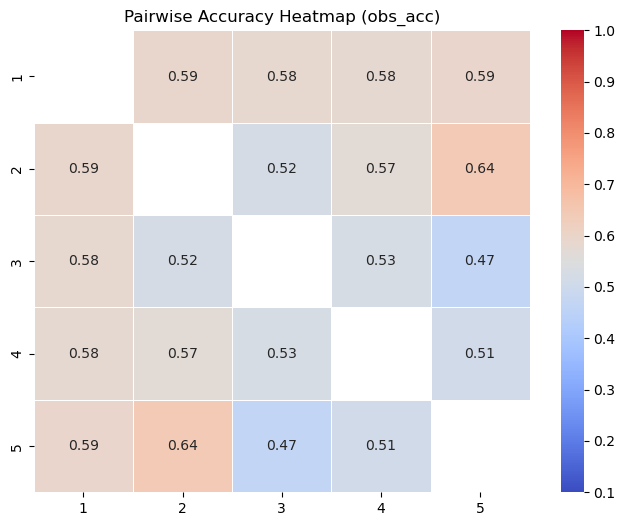

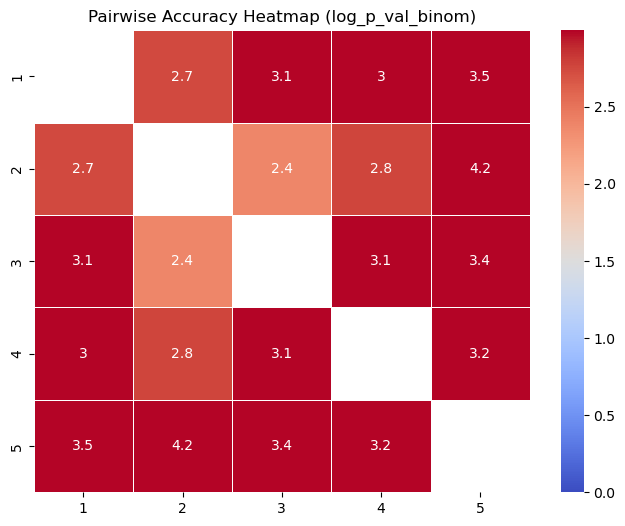

,1,2,3,4,5
1,NaN,2.741908,3.115933,3.000809,3.505471
2,2.741908,NaN,2.383247,2.764441,4.186293
3,3.115933,2.383247,NaN,3.077076,3.381563
4,3.000809,2.764441,3.077076,NaN,3.173523
5,3.505471,4.186293,3.381563,3.173523,NaN


In [109]:
digits_numerosity_files = glob(op.join(data_dir, '*_labels_numerosity_digits_perm_results.pickle'))

digits_numerosity_results = average_results('digits_numerosity', digits_numerosity_files)

plot_AM(digits_numerosity_results[1], 'obs_acc')

plot_AM(digits_numerosity_results[1], 'log_p_val_binom')